In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
from torch.autograd import Variable

import math

from blackhc.mdp import dsl
from blackhc import mdp
import time

from blackhc.mdp import lp
import functools
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt


# Importance Sampling-based Agent

In [2]:
# Follow SARSA format

def cvt_axis(trajs):
    t_states = []
    t_actions = []
    t_rewards = []
    t_nstates = []
    t_log_probs = []

    for traj in trajs:
        t_states.append(traj[0])
        t_actions.append(traj[1])
        t_rewards.append(traj[2])
        t_nstates.append(traj[3])
        t_log_probs.append(traj[4])

    return (t_states, t_actions, t_rewards,t_states,t_log_probs)

def reward_to_value(t_rewards, gamma):

    t_Rs = []

    for rewards in t_rewards:
        Rs = []
        R = torch.zeros(1, 1)

        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            Rs.insert(0, R)
        t_Rs.append(Rs)
        
    return(t_Rs)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)



class Network(nn.Module):

    def __init__(self, input_layer,output_layer):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_layer, output_layer,bias=False)
        self.fc2=nn.Softmax(dim=1)

    def forward(self, input_):
        x=self.fc1(input_)
        y=self.fc2(x)
        return y


class Agent():

    def __init__(self,observation_space, action_space):

        self.model = Network(observation_space.n,action_space.n)
        self.gamma = 0.99
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.model.train()


    def action(self, state):
        
        probs = self.model(Variable(state))
        action = probs.multinomial(1).data
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(action, log_prob)


    def cal_log_prob(self, state, action):

        probs = self.model(Variable(state))
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(log_prob)


    def train_(self, trajs):
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = cvt_axis(trajs)
        t_Rs = reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(states[t], actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z


        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()

# Defining MDP-following openai gym structure

In [3]:
def  _multi_round_nmdp_simple():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(0) | dsl.reward(0)
        start & A_0 > start * 1 | S_1
        start & A_1 > dsl.reward(0) | dsl.reward(5) | dsl.reward(0)
        start & A_1 > start * 1 | end * 5 | S_1 * 1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(5)
        S_1 & A_1 > start * 3 | end
        
        dsl.discount(0.5)

        return mdp.validate()
    
def  _multi_round_nmdp_complex():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        S_2=dsl.state()
        S_3=dsl.state()
        S_4=dsl.state()
        S_5=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(10) | dsl.reward(0)
        start & A_0 > start * 1 | end
        start & A_1 > dsl.reward(0) | dsl.reward(0)
        start & A_1 > start * 1 | S_1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_1 > S_1 * 1 | S_2
        
        S_2 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_0 > S_2 * 1 | S_1
        S_2 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_1 > S_2 * 1 | S_3
        
        S_3 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_0 > S_3 * 1 | S_2
        S_3 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_1 > S_3 * 1 | S_4
        
        S_4 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_0 > S_4 * 1 | S_3
        S_4 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_1 > S_4 * 1 | S_5
        
        S_5 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_5 & A_0 > S_5 * 1 | S_4
        S_5 & A_1 > dsl.reward(10) | dsl.reward(0)
        S_5 & A_1 > end * 1 | S_1
        
        dsl.discount(0.5)

        return mdp.validate() 

MULTI_ROUND_NDMP = _multi_round_nmdp_simple()



solver = lp.LinearProgramming(MULTI_ROUND_NDMP)
solver.compute_q_table(max_iterations=10000, all_close=functools.partial(np.allclose, rtol=1e-10, atol=1e-10))
# mdp.display_mdp(MULTI_ROUND_NDMP)


array([[1.32838284, 2.04620462],
       [1.32838284, 3.26732673],
       [0.        , 0.        ]])

In [4]:
env = MULTI_ROUND_NDMP.to_env()
A1=Agent(env.observation_space,env.action_space)


In [5]:
def display_env():    
    env.render()
    env.render_widget.width=500
    time.sleep(0.200)

# Graphical-representation of the MDP 

In [6]:
display_env()

Image(value=b'')

# Off-policy policy gradient 

In [7]:
# A1.model
init_weights(A1.model)
env.reset()
print(list(A1.model.fc1.parameters()))

s_t_index=env._state.index
s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
s_t=s_t.type(torch.FloatTensor)

trajs=[]
result=[]

for traj_id in range(5):
    env.reset()
    # display_env()
    s_t_index=env._state.index
    
    states=[]
    log_probs=[]
    rewards=[]
    actions=[]
    nstates=[]
    
    for t in range(8):
        s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
        s_t=s_t.type(torch.FloatTensor)
        a_t, log_prob = A1.action(s_t)
        ns_t, r_t, done, _ = env.step(a_t.numpy()[0][0])
        # print(env._state.name)
        # display_env()
        if t!=0:
            nstates.append(s_t)
        states.append(s_t)
        actions.append(a_t)
        log_probs.append(log_prob)
        rewards.append(r_t)
        s_t_index=ns_t
        if done:
            break
    time.sleep(2)
    s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
    s_t=s_t.type(torch.FloatTensor)
    nstates.append(s_t)
    

    trajs.append((states, actions, rewards,nstates, log_probs))
    A1.train_(trajs)
    # print("\n")
    print(states)
    print(actions)
    print(rewards)
    print(nstates)
    # print("Episode: {}, reward: {}".format(traj_id, sum(rewards)))
    result.append(sum(rewards))

print(list(A1.model.fc1.parameters()))


[Parameter containing:
tensor([[-0.0728, -0.2456,  0.3821],
        [ 0.4320,  0.1592,  0.1457]], requires_grad=True)]
[tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]])]
[tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[1]]), tensor([[0]]), tensor([[1]])]
[0, 0, 0, 0, 0, 0, 0, 0]
[tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]])]
[tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]])]
[tensor([[0]]), tensor([[1]]), tensor([[1]]), tensor([[1]])]
[0, 0, 0, 5]
[tensor([[0., 1., 0.]]), tensor([[1., 0., 0.]]), tensor([[0., 1., 0.]]), tensor([[0., 0., 1.]])]
[tensor([[0., 1., 0.]])]
[tensor([[1]])]
[5]
[tensor([[0., 0., 1.]])]
[tensor([[0

In [8]:
solver.compute_q_table(max_iterations=10000, all_close=functools.partial(np.allclose, rtol=1e-10, atol=1e-10))

array([[1.32838284, 2.04620462],
       [1.32838284, 3.26732673],
       [0.        , 0.        ]])

# plotting episodes vs rewards

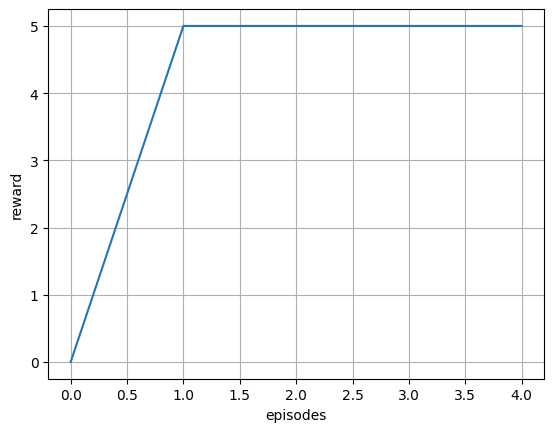

In [10]:
plt.plot(range(len(result)), result)
plt.ylabel('reward')
plt.xlabel('episodes')
plt.grid(True)
plt.show()

env.close()